In [207]:
import pandas
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np

In [208]:
np.random.seed(7)

In [209]:
# number of features used in the regression
window_size = 10
# lstm_num_timesteps
lstm_num_timesteps = 10
# whether to use LSTM or MLP
use_LSTM = True
# lstm_num_features
lstm_num_features = 1

In [210]:
# load the dataset
dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

In [211]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [212]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


96 48


In [213]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, window_size):
    dataX, dataY = [], []
    for i in range(len(dataset)-window_size-1):
        a = dataset[i:(i+window_size), 0]
        dataX.append(a)
        dataY.append(dataset[i + window_size, 0])
    return np.array(dataX), np.array(dataY)

In [214]:
trainX, trainY = create_dataset(train, window_size)
testX, testY = create_dataset(test, window_size)
trainX.shape, testX.shape, trainY.shape, testY.shape

((85, 10), (37, 10), (85,), (37,))

In [215]:
trainX[0:5,:]

array([[ 0.01544401,  0.02702703,  0.05405405,  0.04826255,  0.03281853,
         0.05984557,  0.08494207,  0.08494207,  0.06177607,  0.02895753],
       [ 0.02702703,  0.05405405,  0.04826255,  0.03281853,  0.05984557,
         0.08494207,  0.08494207,  0.06177607,  0.02895753,  0.        ],
       [ 0.05405405,  0.04826255,  0.03281853,  0.05984557,  0.08494207,
         0.08494207,  0.06177607,  0.02895753,  0.        ,  0.02702703],
       [ 0.04826255,  0.03281853,  0.05984557,  0.08494207,  0.08494207,
         0.06177607,  0.02895753,  0.        ,  0.02702703,  0.02123553],
       [ 0.03281853,  0.05984557,  0.08494207,  0.08494207,  0.06177607,
         0.02895753,  0.        ,  0.02702703,  0.02123553,  0.04247104]], dtype=float32)

In [216]:
trainY[0:5]

array([ 0.        ,  0.02702703,  0.02123553,  0.04247104,  0.07142857], dtype=float32)

In [217]:
if use_LSTM:
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], lstm_num_timesteps, lstm_num_features))
    testX = np.reshape(testX, (testX.shape[0], lstm_num_timesteps, lstm_num_features))

In [218]:
model = Sequential()

if use_LSTM:
    model.add(LSTM(4, input_dim=lstm_num_features))
else:
    model.add(Dense(8, input_dim=window_size, activation='relu'))
    
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

if use_LSTM:
    model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=0)
else:
    model.fit(trainX, trainY, nb_epoch=200, batch_size=2, verbose=0)

In [219]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 20.92 RMSE
Test Score: 56.21 RMSE


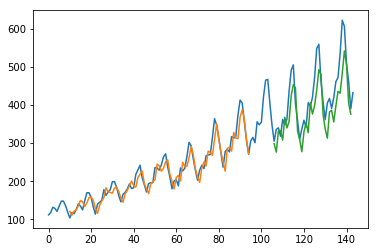

In [220]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window_size:len(trainPredict)+window_size, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(window_size*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()